# Initial codes

This notebook illustrates how Bayesian inference can be used to infer response rates of each group (basket) in a Basket trial.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('../..')

In [3]:
from collections import defaultdict

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import arviz as az
import pymc as pm
from IPython.display import display

# Define some useful classes

## Create a class to respresent a group, i.e. a basket

In [5]:
class Group():
    def __init__(self, group_id, true_response_rate=None):
        self.idx = group_id
        self.true_response_rate = true_response_rate
        self.responses = []
                
    def enroll(self, num_patient):
        responses = self.sample(num_patient)
        self.responses.extend(responses)   
        return self.responses
    
    def sample(self, num_patient):
        if self.true_response_rate is None:
            return np.array([])
        else:
            return stats.binom.rvs(1, self.true_response_rate, size=num_patient)    
    
    @property
    def response_indices(self):
        return [self.idx] * len(self.responses)
            
    def __repr__(self):
        return 'Group %d (true θ=%.2f) %s' % (self.idx, self.true_response_rate, self.responses)

## Create a class to represent a Trial

Can be called sequentially to enroll patients into groups. Uses pymc to infer groups' response rate

Three models are defined inside the `get_model()` method of this class:
- `independent`: independent Beta-Binomial models with no parameter sharing.
- `hierarchical`: Beta-Binomial models with parameter sharing (using Gamma priors).
- `bhm`: Normal with hierarchical priors following [Berry et al. 2013](https://journals.sagepub.com/doi/full/10.1177/1740774513497539). Ported to pymc from the JAGS implementation in https://github.com/Jin93/CBHM/blob/master/BHM.txt.

In [6]:
class Trial():
    def __init__(self, K, p0, p1, true_response_rates, enrollment, 
                 evaluate_interim, num_burn_in, num_posterior_samples, model_names):
        self.K = K
        self.p0 = p0
        self.p1 = p1
        self.num_burn_in = int(num_burn_in)
        self.num_posterior_samples = int(num_posterior_samples)
        self.model_names = model_names
        
        assert len(true_response_rates) == K
        assert len(enrollment) == len(evaluate_interim)
        self.true_response_rates = true_response_rates
        self.enrollment = enrollment
        self.evaluate_interim = evaluate_interim        
                
    def reset(self):
        self.current_stage = 0        
        self.inference_results = defaultdict(list)
        self.total_enrolled = 0
        self.groups = [Group(k, self.true_response_rates[k]) for k in range(self.K)]
        self.total_enrolled = 0
        self.last_models = {}
        return False
        
    def step(self):
        num_patient = enrollment[self.current_stage]
        self.total_enrolled += num_patient
        print('\n########## Stage=%d Enrolled = %d ##########' % (self.current_stage, self.total_enrolled) )

        # simulate enrollment
        observed_data = []
        group_idx = []

        for group in self.groups:
            group.enroll(num_patient)        
            print(group)        

            observed_data.extend(group.responses)
            group_idx.extend(group.response_indices)        
        print()

        if not self.evaluate_interim[self.current_stage]:
            self.current_stage += 1
            return True if self.current_stage == len(self.enrollment) else False

        # do inference
        for model_name in model_names:
            model = self.get_model(model_name, observed_data, group_idx)
            self.last_models[model_name] = model
            res = self.inference(model, self.num_posterior_samples, self.num_burn_in)
            self.inference_results[model_name].append(res)        

        self.current_stage += 1
        return True if self.current_stage == len(self.enrollment) else False

    
    def get_model(self, model_name, observed_data, group_idx):
        assert model_name in ['independent', 'hierarchical', 'bhm']
        print('\nmodel_name', model_name)

        observed_data = np.array(observed_data)
        group_idx = np.array(group_idx)
        unique_group_idx = np.unique(group_idx)
        num_groups = len(unique_group_idx)

        ns = [ len(observed_data[group_idx == idx]) for idx in unique_group_idx ]
        ks = [ np.sum(observed_data[group_idx == idx]) for idx in unique_group_idx ]

        if model_name == 'independent':    
            with pm.Model() as model:

                θ = pm.Beta('θ', alpha=1, beta=1, shape=num_groups)
                y = pm.Binomial('y', n=ns, p=θ, observed=ks)

                return model        

        elif model_name == 'hierarchical':        
            with pm.Model() as model:

                α = pm.Gamma('α', alpha=4, beta=0.5)
                β = pm.Gamma('β', alpha=4, beta=0.5)            

                θ = pm.Beta('θ', alpha=α, beta=β, shape=num_groups)
                y = pm.Binomial('y', n=ns, p=θ, observed=ks)

                return model
            
        elif model_name == 'bhm':
            mu0 = np.log(self.p0/(1-self.p0))            
            with pm.Model() as model:
                
                tausq = pm.Gamma('tausq', alpha=0.001, beta=0.001)
                theta_0 = pm.Normal('theta0', mu=-mu0, sigma=0.001)

                e = pm.Normal('e', mu=0, sigma=tausq, shape=num_groups)
                theta = pm.Deterministic('theta', theta_0 + e)
                p = pm.Deterministic('p', np.exp(theta) / (1+np.exp(theta)))
                y = pm.Binomial('y', n=ns, p=p, observed=ks)

                return model
            

    def inference(self, model, num_posterior_samples, num_burn_in):
        with model:
            inference_data = pm.sample(draws=num_posterior_samples, tune=num_burn_in, return_inferencedata=True)
            return inference_data
        
    def visualise_model(self, model_name):
        model = self.last_models[model_name]
        display(pm.model_to_graphviz(model))
        
    def plot_trace(self, model_name, pos):
        res = self.inference_results[model_name][pos]
        az.plot_trace(res)
        
    def plot_posterior(self, model_name, pos):
        res = self.inference_results[model_name][pos]
        az.plot_posterior(res)

## Example 1: treatment is of interest in all groups

Same example as in [Berry et al. 2013](https://journals.sagepub.com/doi/full/10.1177/1740774513497539) (Figure 1).

4 groups are present in the trial, and all group response rates to the treatment are the same (0.3). The trial enrolls patients in 6 stages, first taking 10 patient for each group in the first stage, followed by 5 patients for each group in latter stages.

> The first example is a scenario in which responses are simulated assuming p = 30% in all four groups. This example illustrates the effect of borrowing across groups when all groups are similar, such as the smoothing of the observed response rates and a reduction in uncertainty.

### Generate data

In [7]:
K = 4    # the number of groups
p0 = 0.1 # null response rate
p1 = 0.3 # target response rate

true_response_rates = [p1, p1, p1, p1]
enrollment = [10, 5, 5, 5, 5, 5]

evaluate_interim = [False, False, False, False, False, True] # only evaluate in the last stage
# evaluate_interim = [True, True, True, True, True, True] # evaluate every interim stage

num_burn_in = 1E5
num_posterior_samples = 1E5
model_names = ['independent', 'hierarchical', 'bhm']

In [8]:
trial = Trial(K, p0, p1, true_response_rates, enrollment, evaluate_interim, 
              num_burn_in, num_posterior_samples, model_names)

done = trial.reset()
while not done:
    done = trial.step()


########## Stage=0 Enrolled = 10 ##########
Group 0 (true θ=0.30) [0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
Group 1 (true θ=0.30) [0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
Group 2 (true θ=0.30) [0, 1, 0, 0, 0, 0, 0, 1, 0, 1]
Group 3 (true θ=0.30) [0, 0, 0, 0, 0, 0, 1, 0, 0, 1]


########## Stage=1 Enrolled = 15 ##########
Group 0 (true θ=0.30) [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Group 1 (true θ=0.30) [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
Group 2 (true θ=0.30) [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
Group 3 (true θ=0.30) [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]


########## Stage=2 Enrolled = 20 ##########
Group 0 (true θ=0.30) [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Group 1 (true θ=0.30) [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Group 2 (true θ=0.30) [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 3 (true θ=0.30) [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0]


########## Stage=3 Enrolled = 25 ##########
G

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 100_000 tune and 100_000 draw iterations (400_000 + 400_000 draws total) took 138 seconds.



model_name hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, θ]


Sampling 4 chains for 100_000 tune and 100_000 draw iterations (400_000 + 400_000 draws total) took 268 seconds.



model_name bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tausq, theta0, e]


Sampling 4 chains for 100_000 tune and 100_000 draw iterations (400_000 + 400_000 draws total) took 224 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


### Check last results

### Independent

In [9]:
model_name = model_names[0]

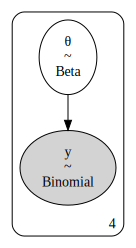

In [10]:
trial.visualise_model(model_name)

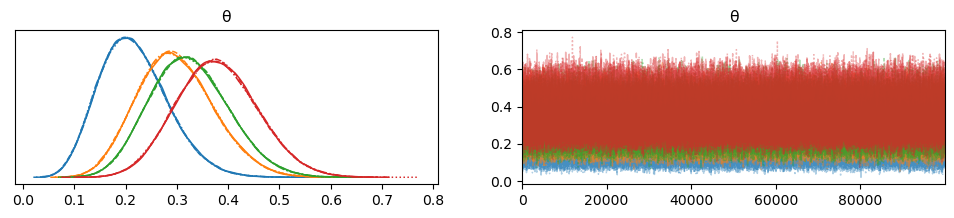

In [11]:
trial.plot_trace(model_name, -1)

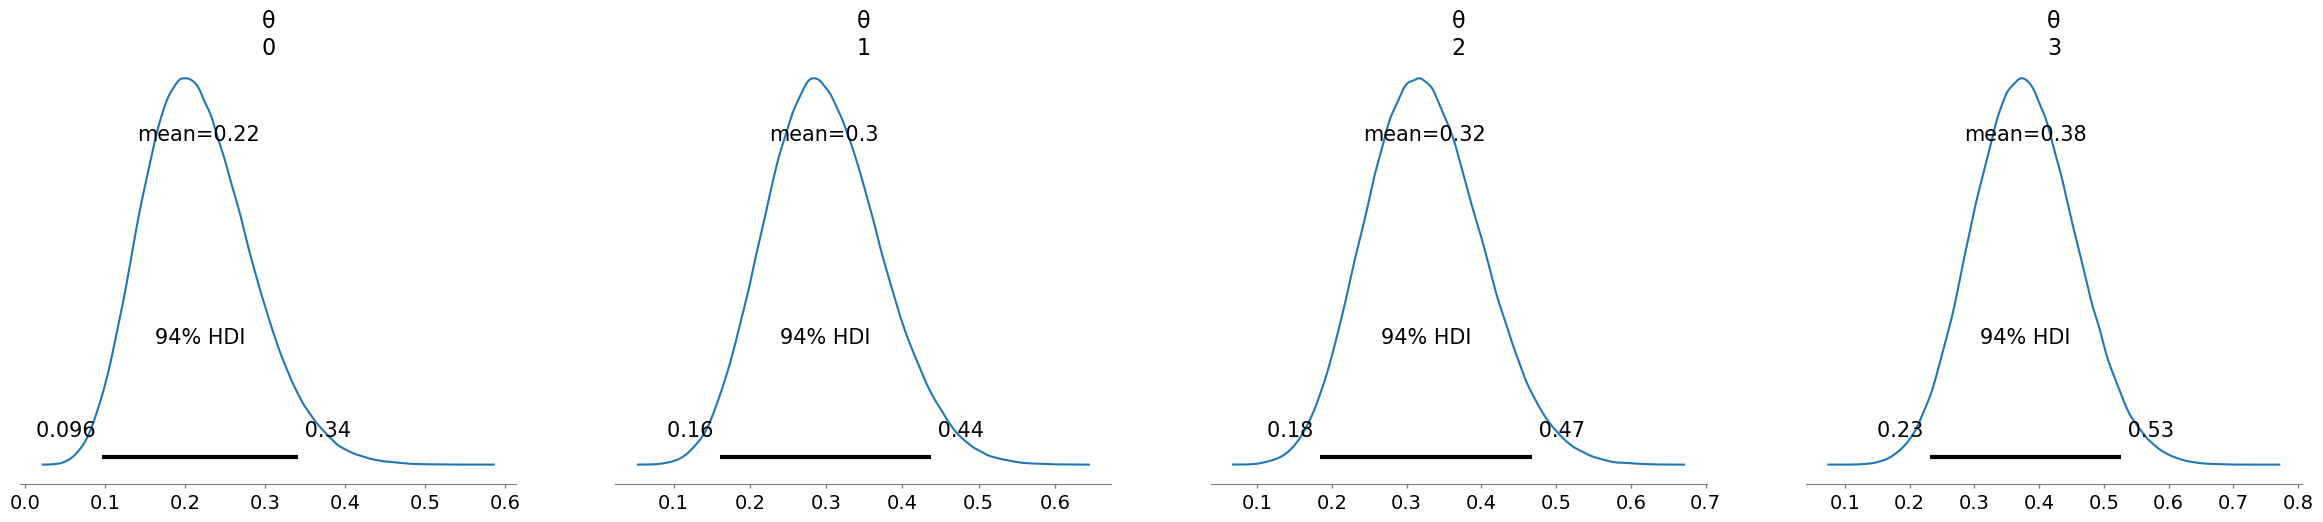

In [12]:
trial.plot_posterior(model_name, -1)

### Hierarchical

In [13]:
model_name = model_names[1]

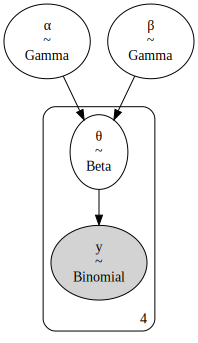

In [14]:
trial.visualise_model(model_name)

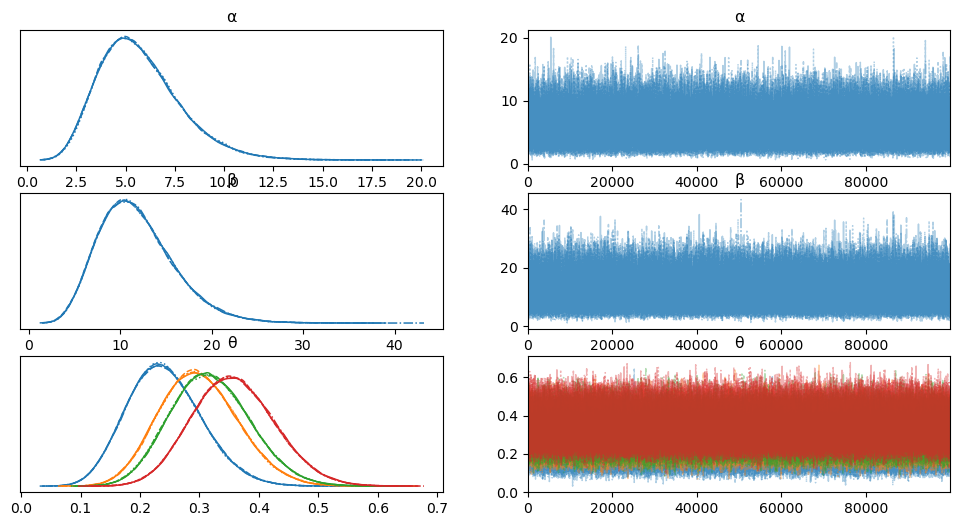

In [15]:
trial.plot_trace(model_name, -1)

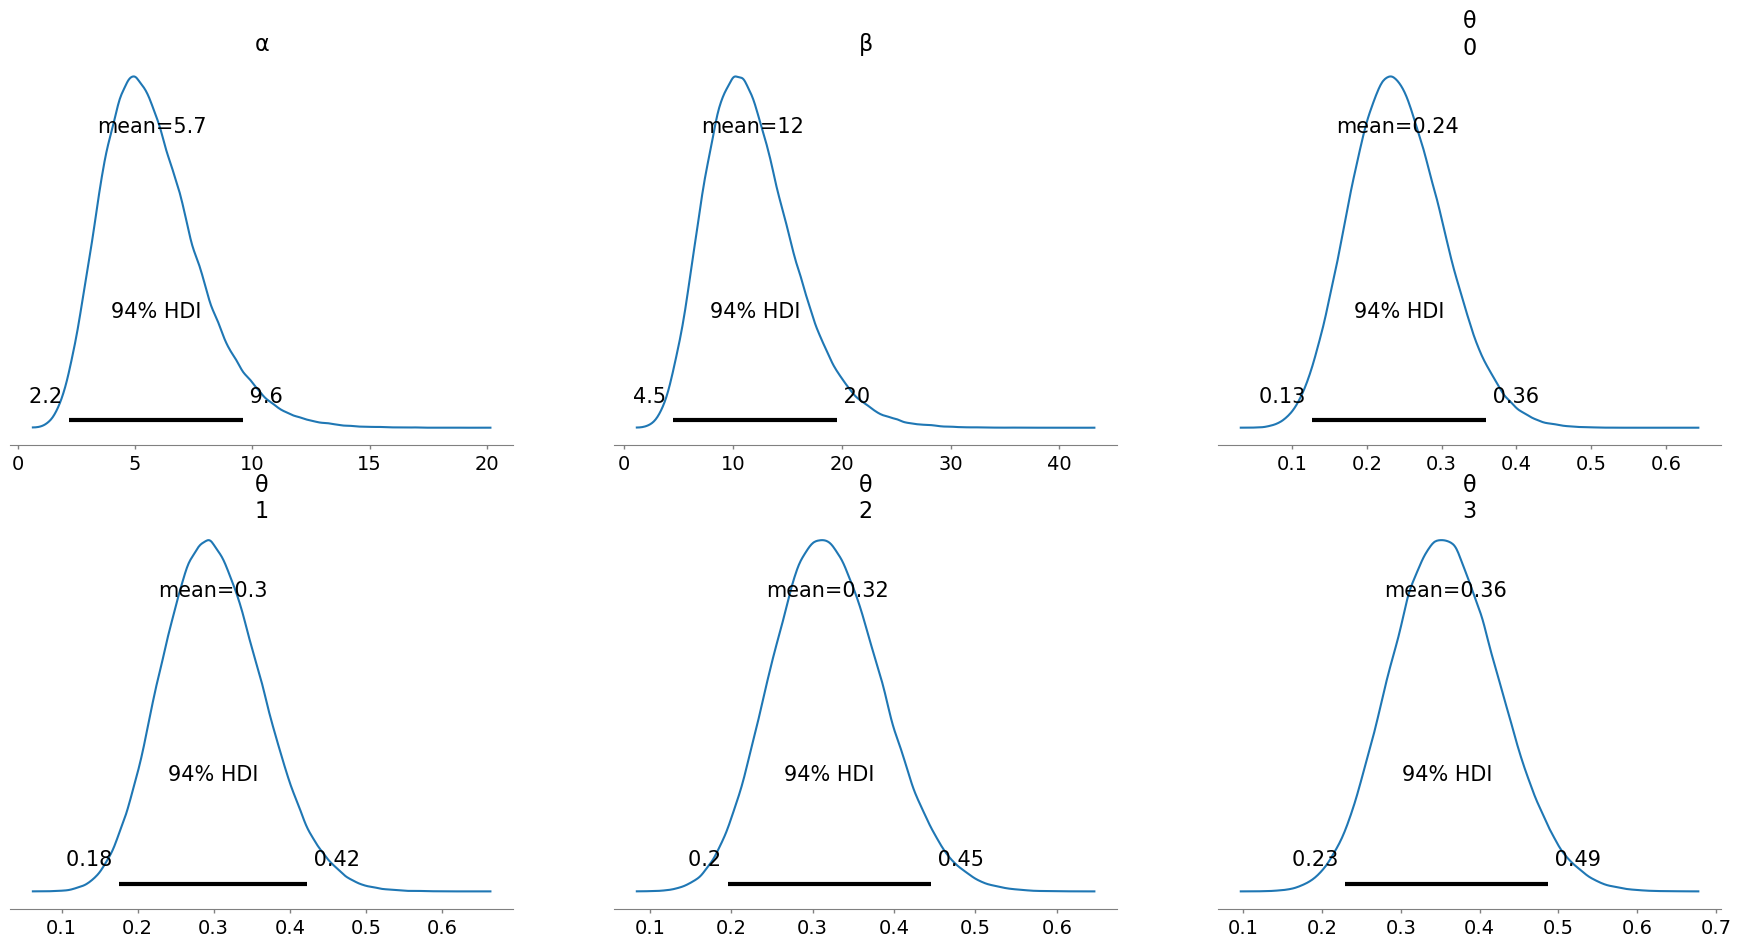

In [16]:
trial.plot_posterior(model_name, -1)

### BHM

In [17]:
model_name = model_names[2]

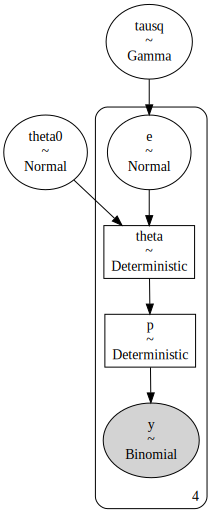

In [18]:
trial.visualise_model(model_name)

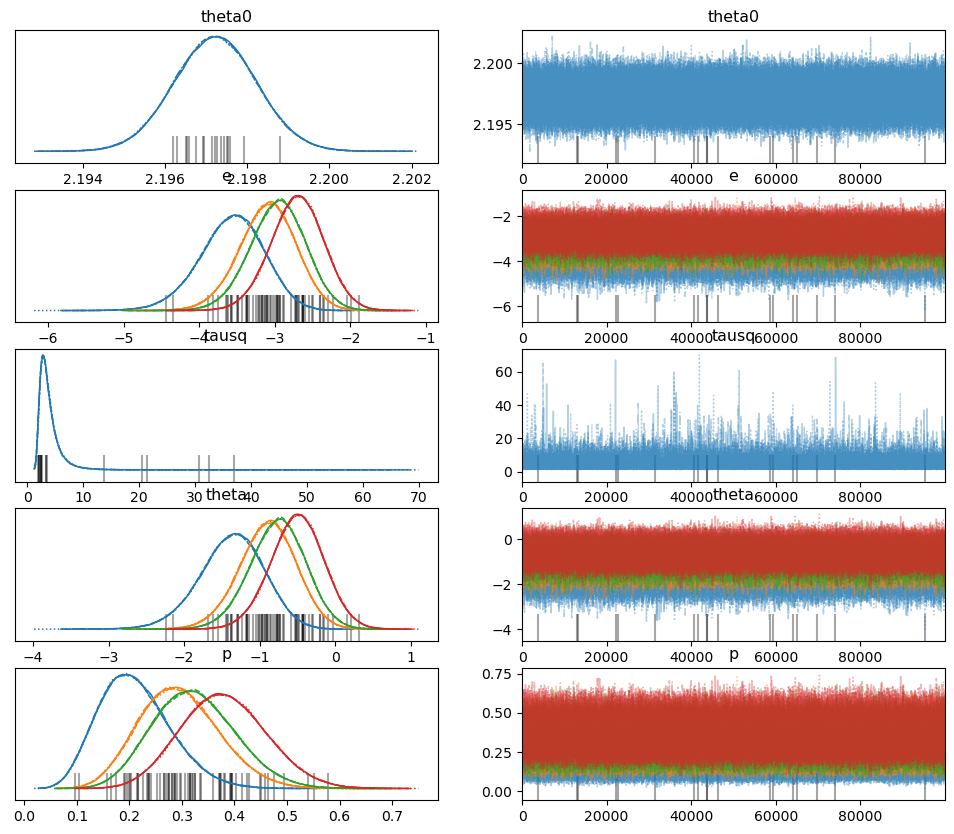

In [19]:
trial.plot_trace(model_name, -1)

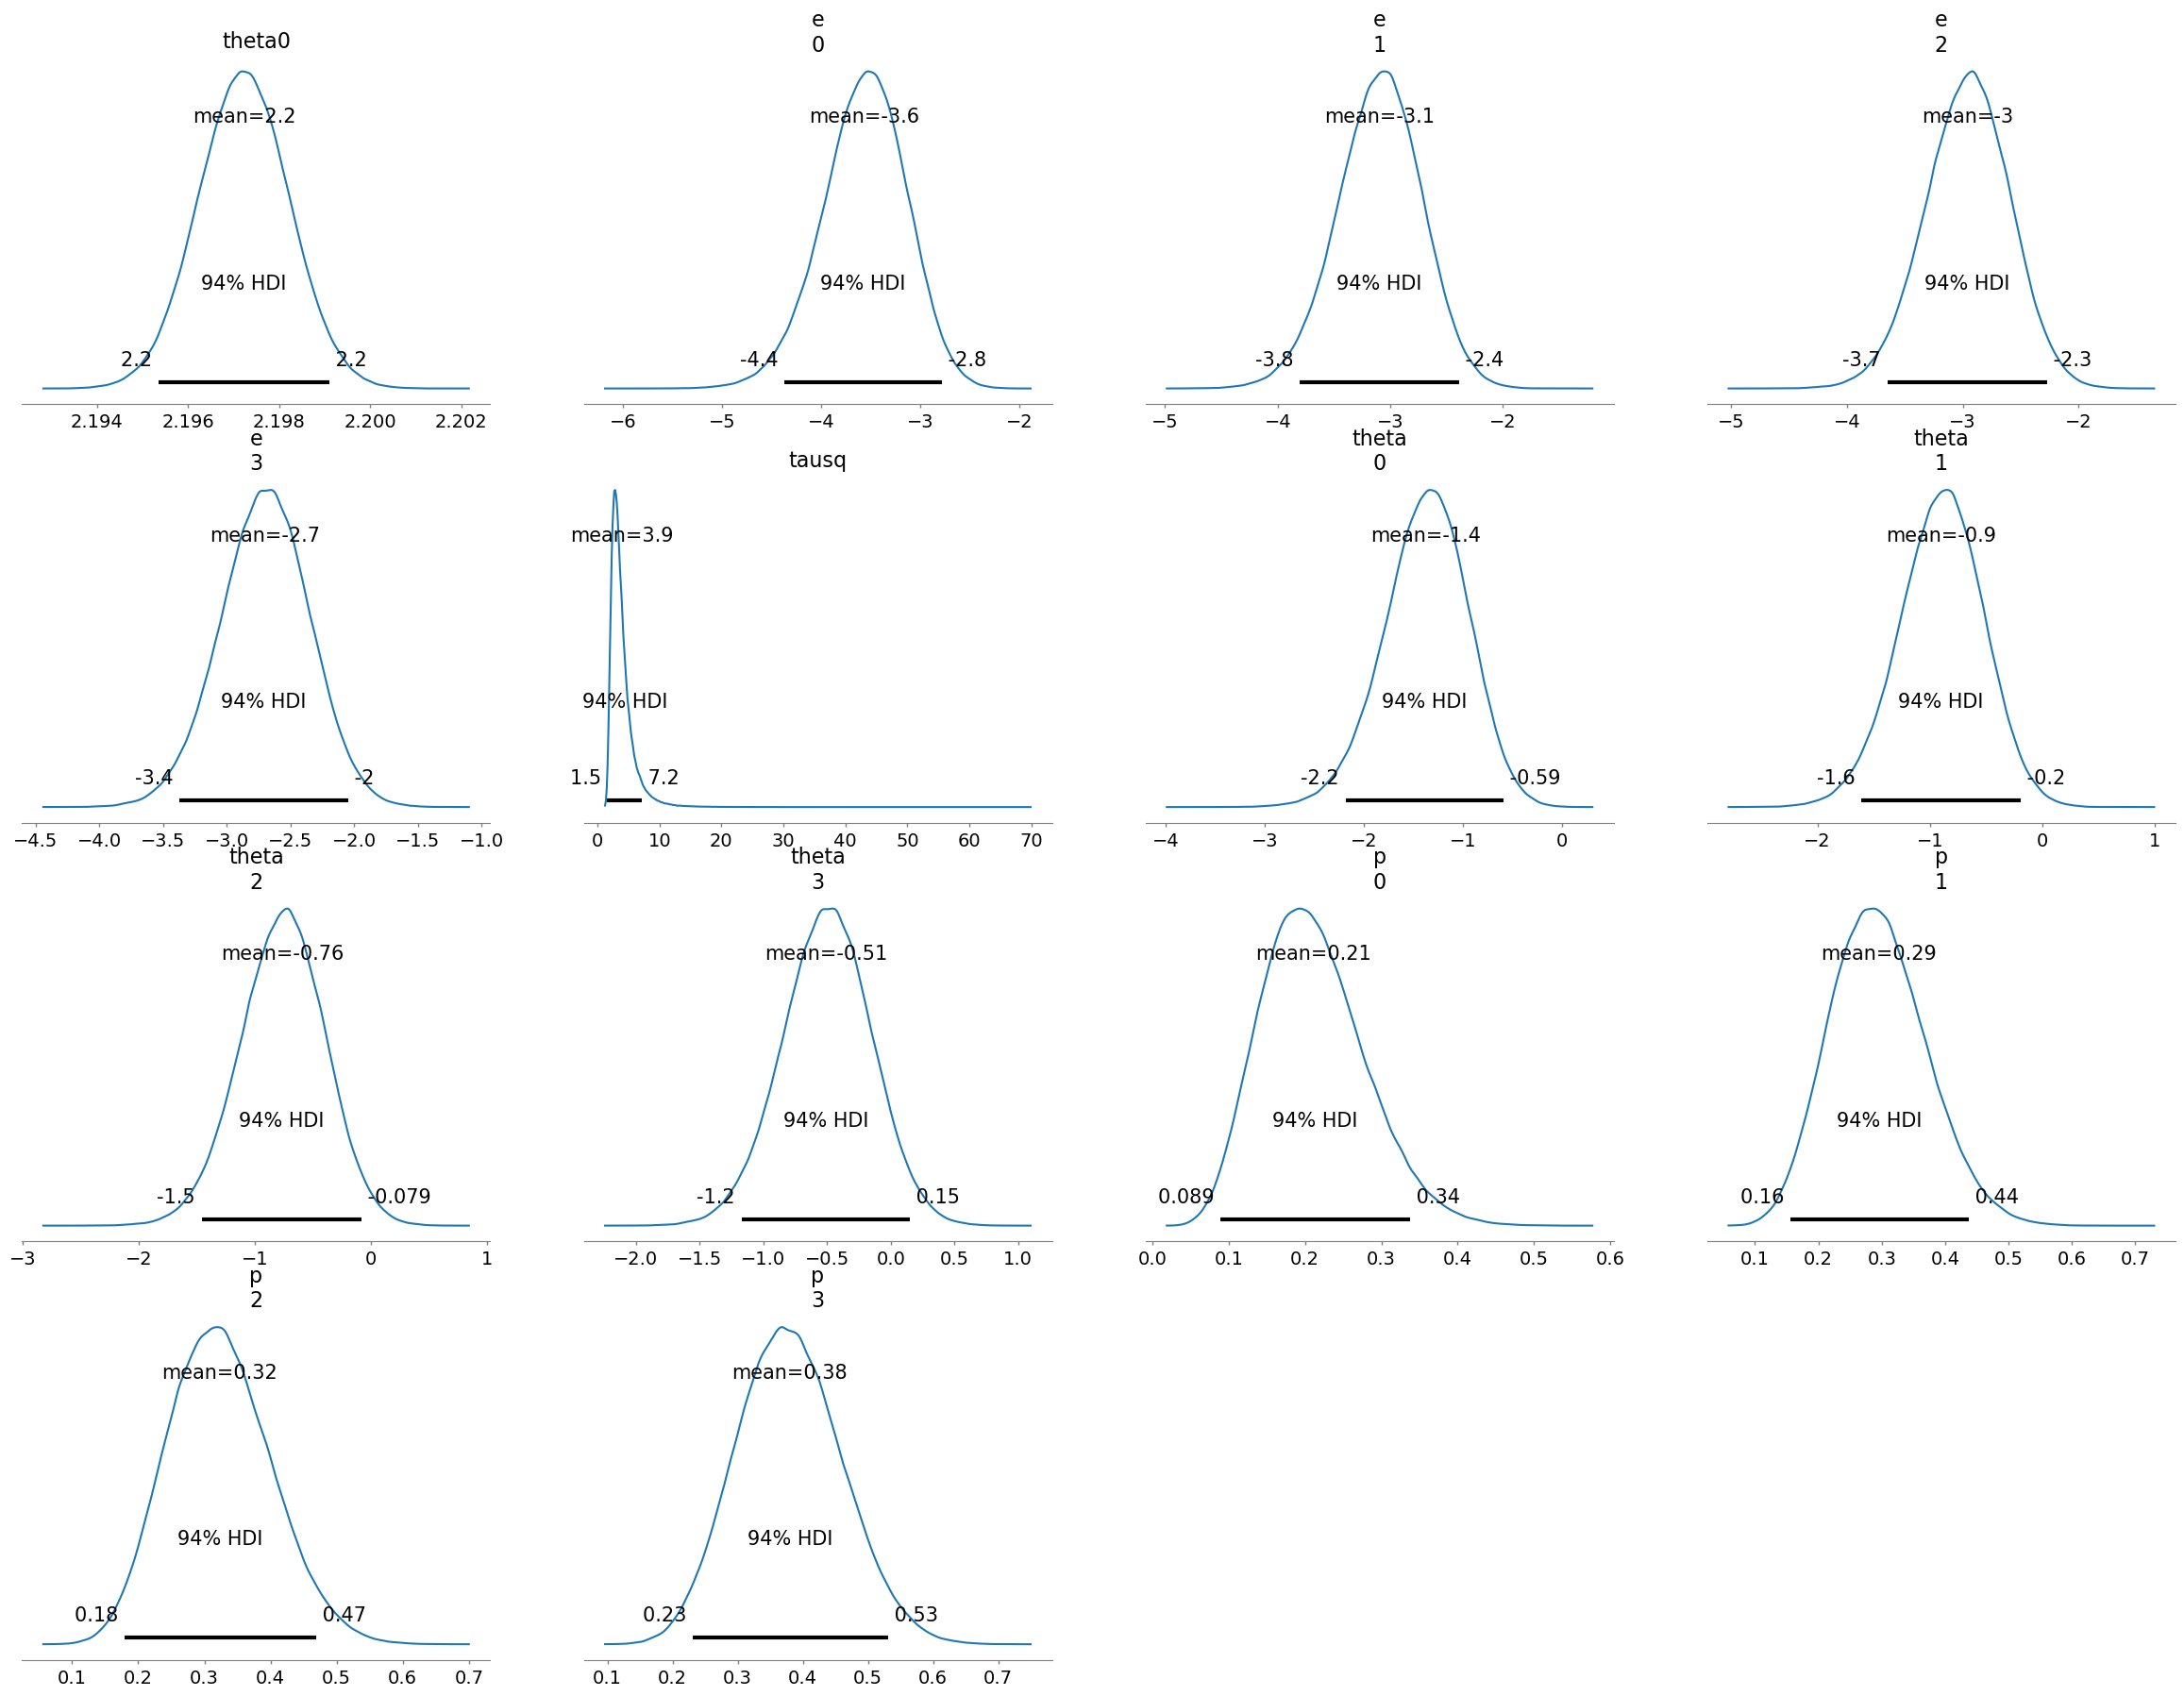

In [20]:
trial.plot_posterior(model_name, -1)

## Example 2: treatment is of interest in only two groups

Same example as in [Berry et al. 2013](https://journals.sagepub.com/doi/full/10.1177/1740774513497539) (Figure 2).

4 groups are present in the group, with first two group responses = 0.10 and the other two groups = 0.3. The trial enrolls patients in 6 stages, first taking 10 patient for each group in the first stage, followed by 5 patients for each group in latter stages.

> The second example is from a scenario in which responses are simulated assuming p = 10% in two groups and p = 30% in two groups. This example illustrates the effect of borrowing, and that the harm is not great, when groups are dissimilar.

### Generate data

In [21]:
K = 4    # the number of groups
p0 = 0.1 # null response rate
p1 = 0.3 # target response rate

true_response_rates = [p0, p0, p1, p1]
enrollment = [10, 5, 5, 5, 5, 5]

evaluate_interim = [False, False, False, False, False, True] # only evaluate in the last stage
# evaluate_interim = [True, True, True, True, True, True] # evaluate every interim stage

num_burn_in = 1E5
num_posterior_samples = 1E5
model_names = ['independent', 'hierarchical', 'bhm']

In [22]:
trial = Trial(K, p0, p1, true_response_rates, enrollment, evaluate_interim, 
              num_burn_in, num_posterior_samples, model_names)

done = trial.reset()
while not done:
    done = trial.step()


########## Stage=0 Enrolled = 10 ##########
Group 0 (true θ=0.10) [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Group 1 (true θ=0.10) [0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Group 2 (true θ=0.30) [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Group 3 (true θ=0.30) [0, 1, 0, 0, 0, 1, 0, 0, 0, 0]


########## Stage=1 Enrolled = 15 ##########
Group 0 (true θ=0.10) [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Group 1 (true θ=0.10) [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Group 2 (true θ=0.30) [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Group 3 (true θ=0.30) [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


########## Stage=2 Enrolled = 20 ##########
Group 0 (true θ=0.10) [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 1 (true θ=0.10) [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Group 2 (true θ=0.30) [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
Group 3 (true θ=0.30) [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]


########## Stage=3 Enrolled = 25 ##########
G

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 100_000 tune and 100_000 draw iterations (400_000 + 400_000 draws total) took 165 seconds.



model_name hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, θ]


Sampling 4 chains for 100_000 tune and 100_000 draw iterations (400_000 + 400_000 draws total) took 302 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7162, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.



model_name bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tausq, theta0, e]


Sampling 4 chains for 100_000 tune and 100_000 draw iterations (400_000 + 400_000 draws total) took 221 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


### Check last results

### Independent

In [23]:
model_name = model_names[0]

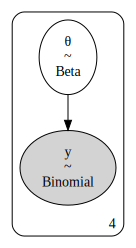

In [24]:
trial.visualise_model(model_name)

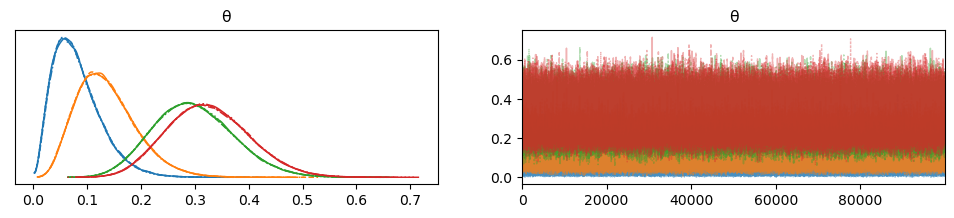

In [25]:
trial.plot_trace(model_name, -1)

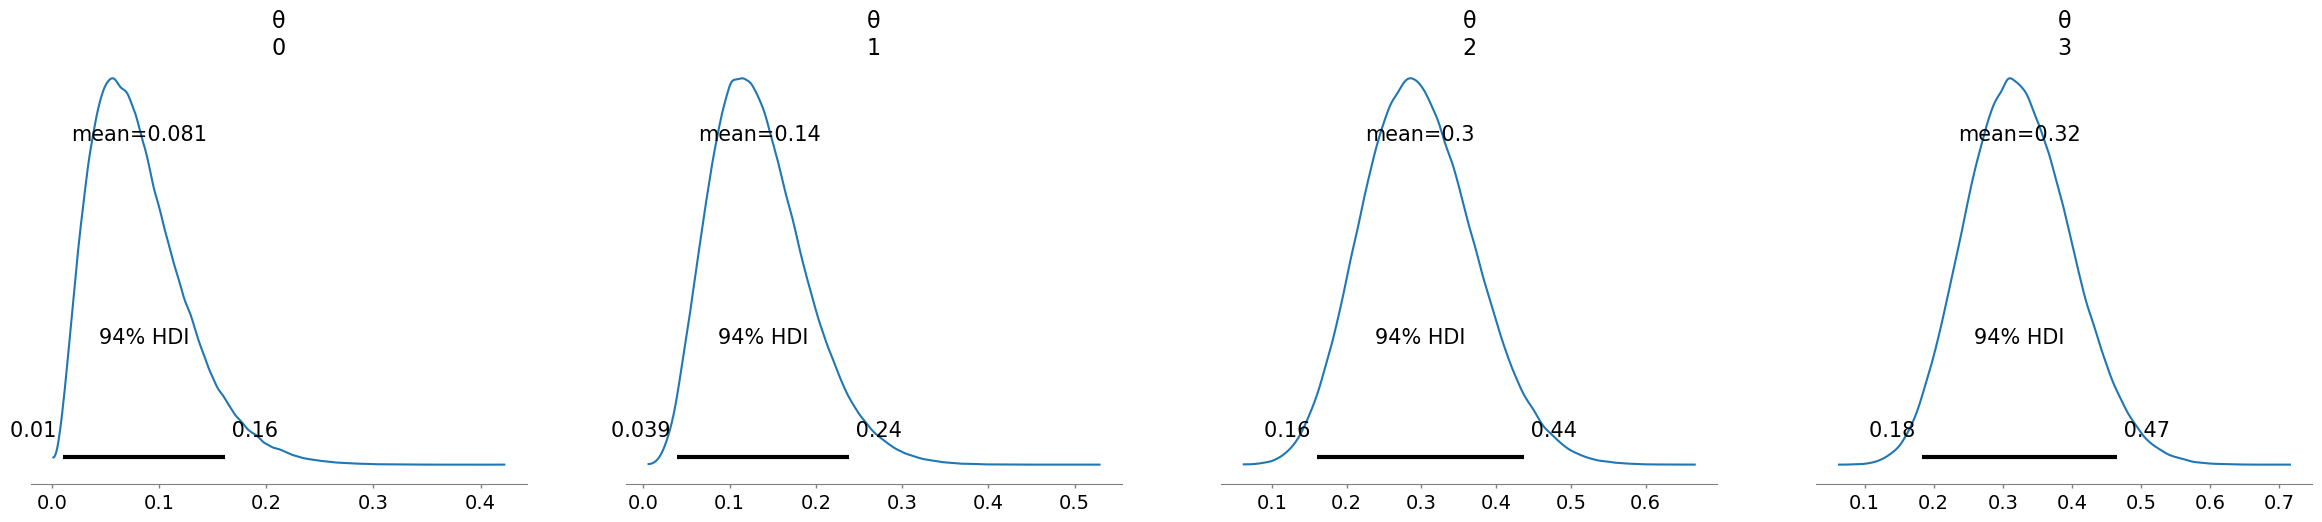

In [26]:
trial.plot_posterior(model_name, -1)

### Hierarchical

In [27]:
model_name = model_names[1]

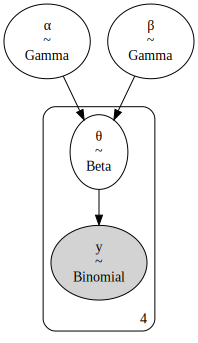

In [28]:
trial.visualise_model(model_name)

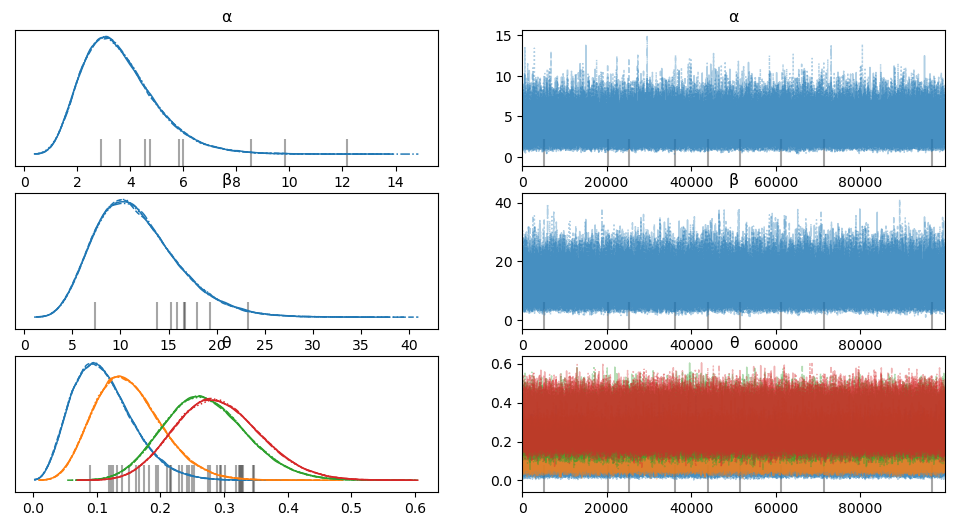

In [29]:
trial.plot_trace(model_name, -1)

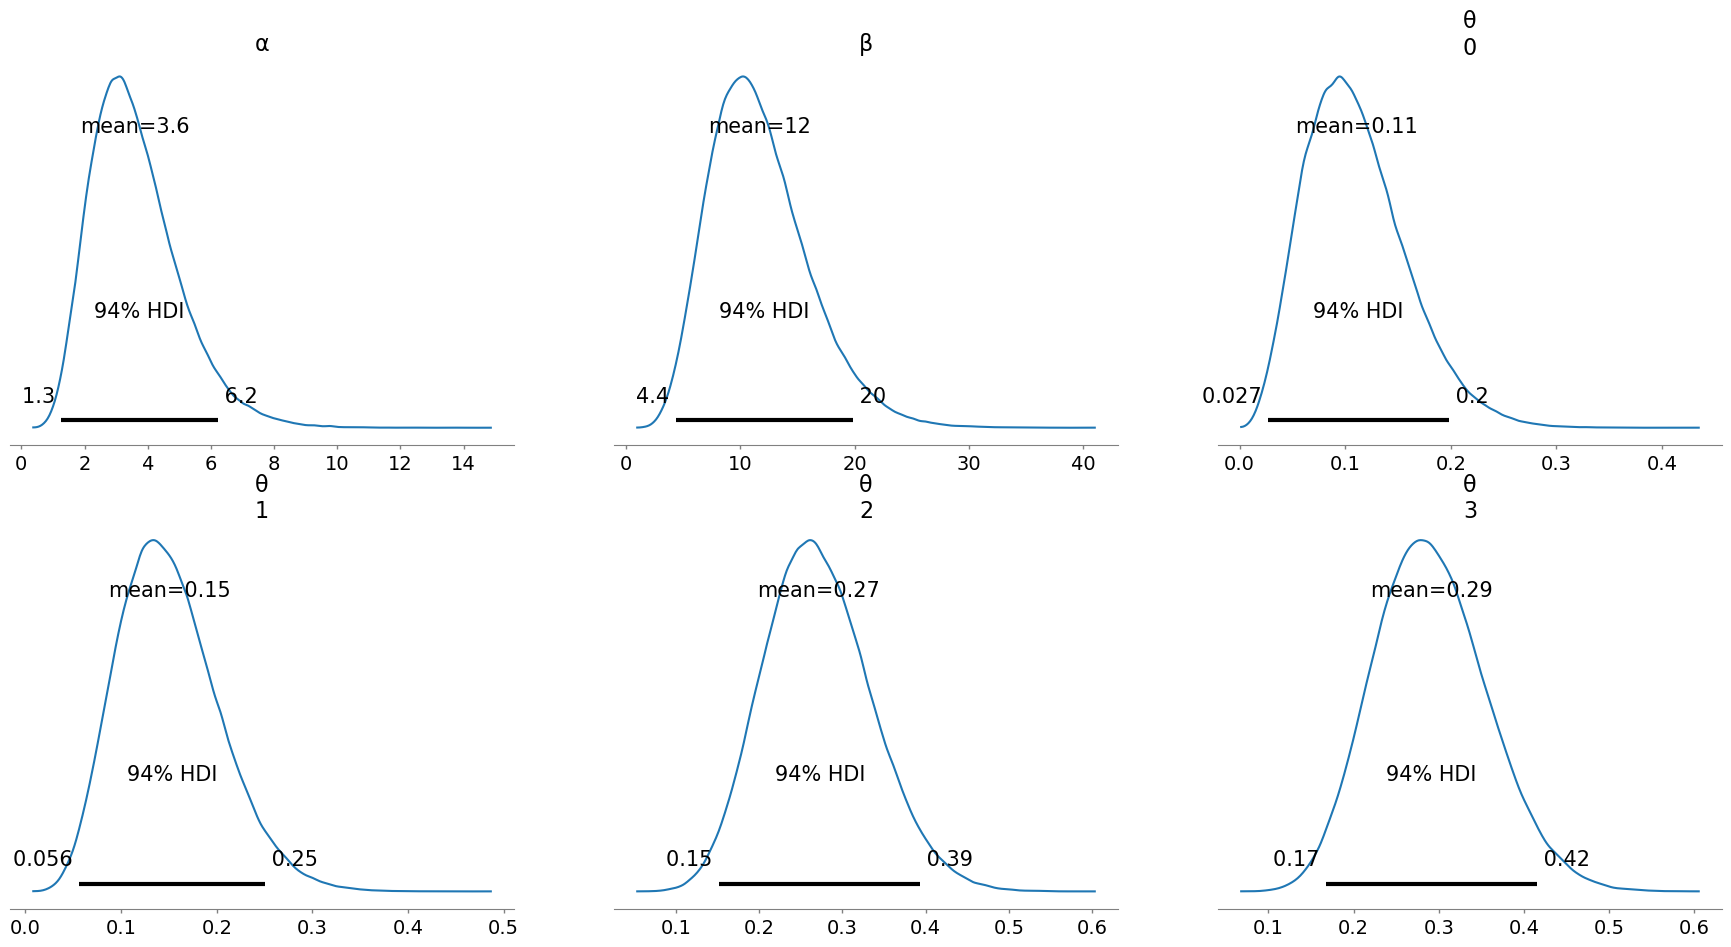

In [30]:
trial.plot_posterior(model_name, -1)

### BHM

In [31]:
model_name = model_names[2]

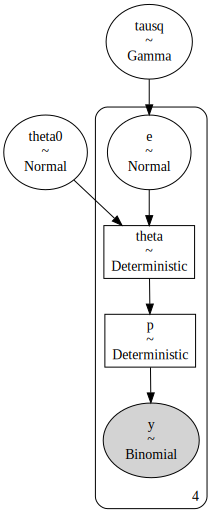

In [32]:
trial.visualise_model(model_name)

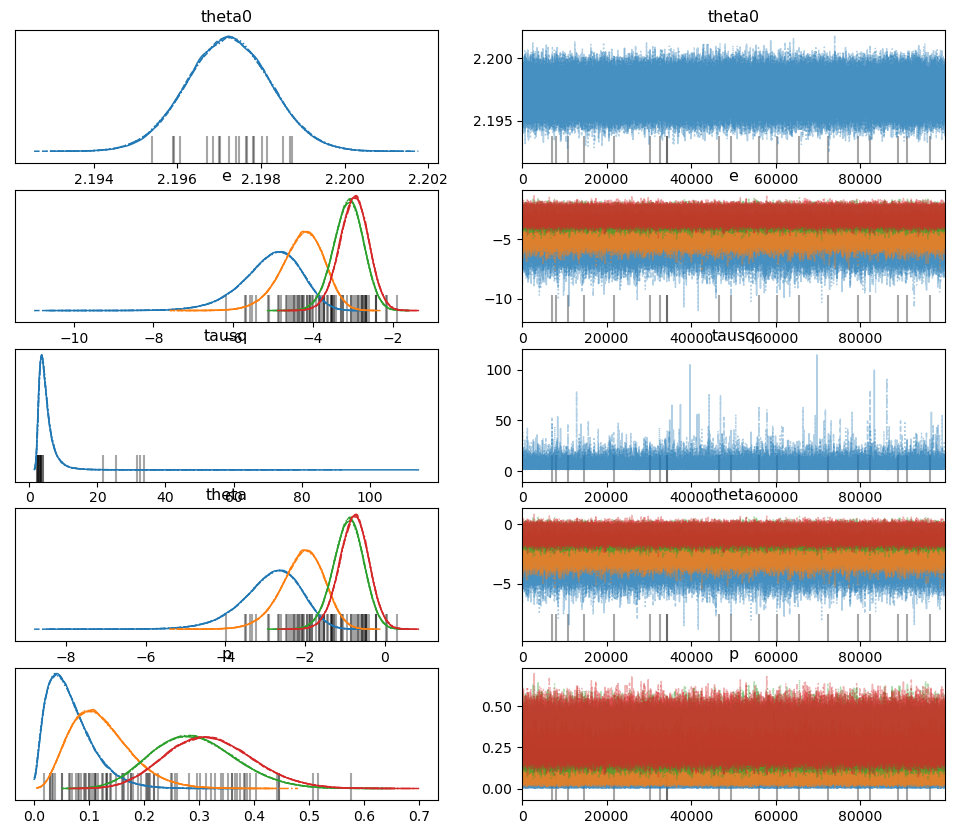

In [33]:
trial.plot_trace(model_name, -1)

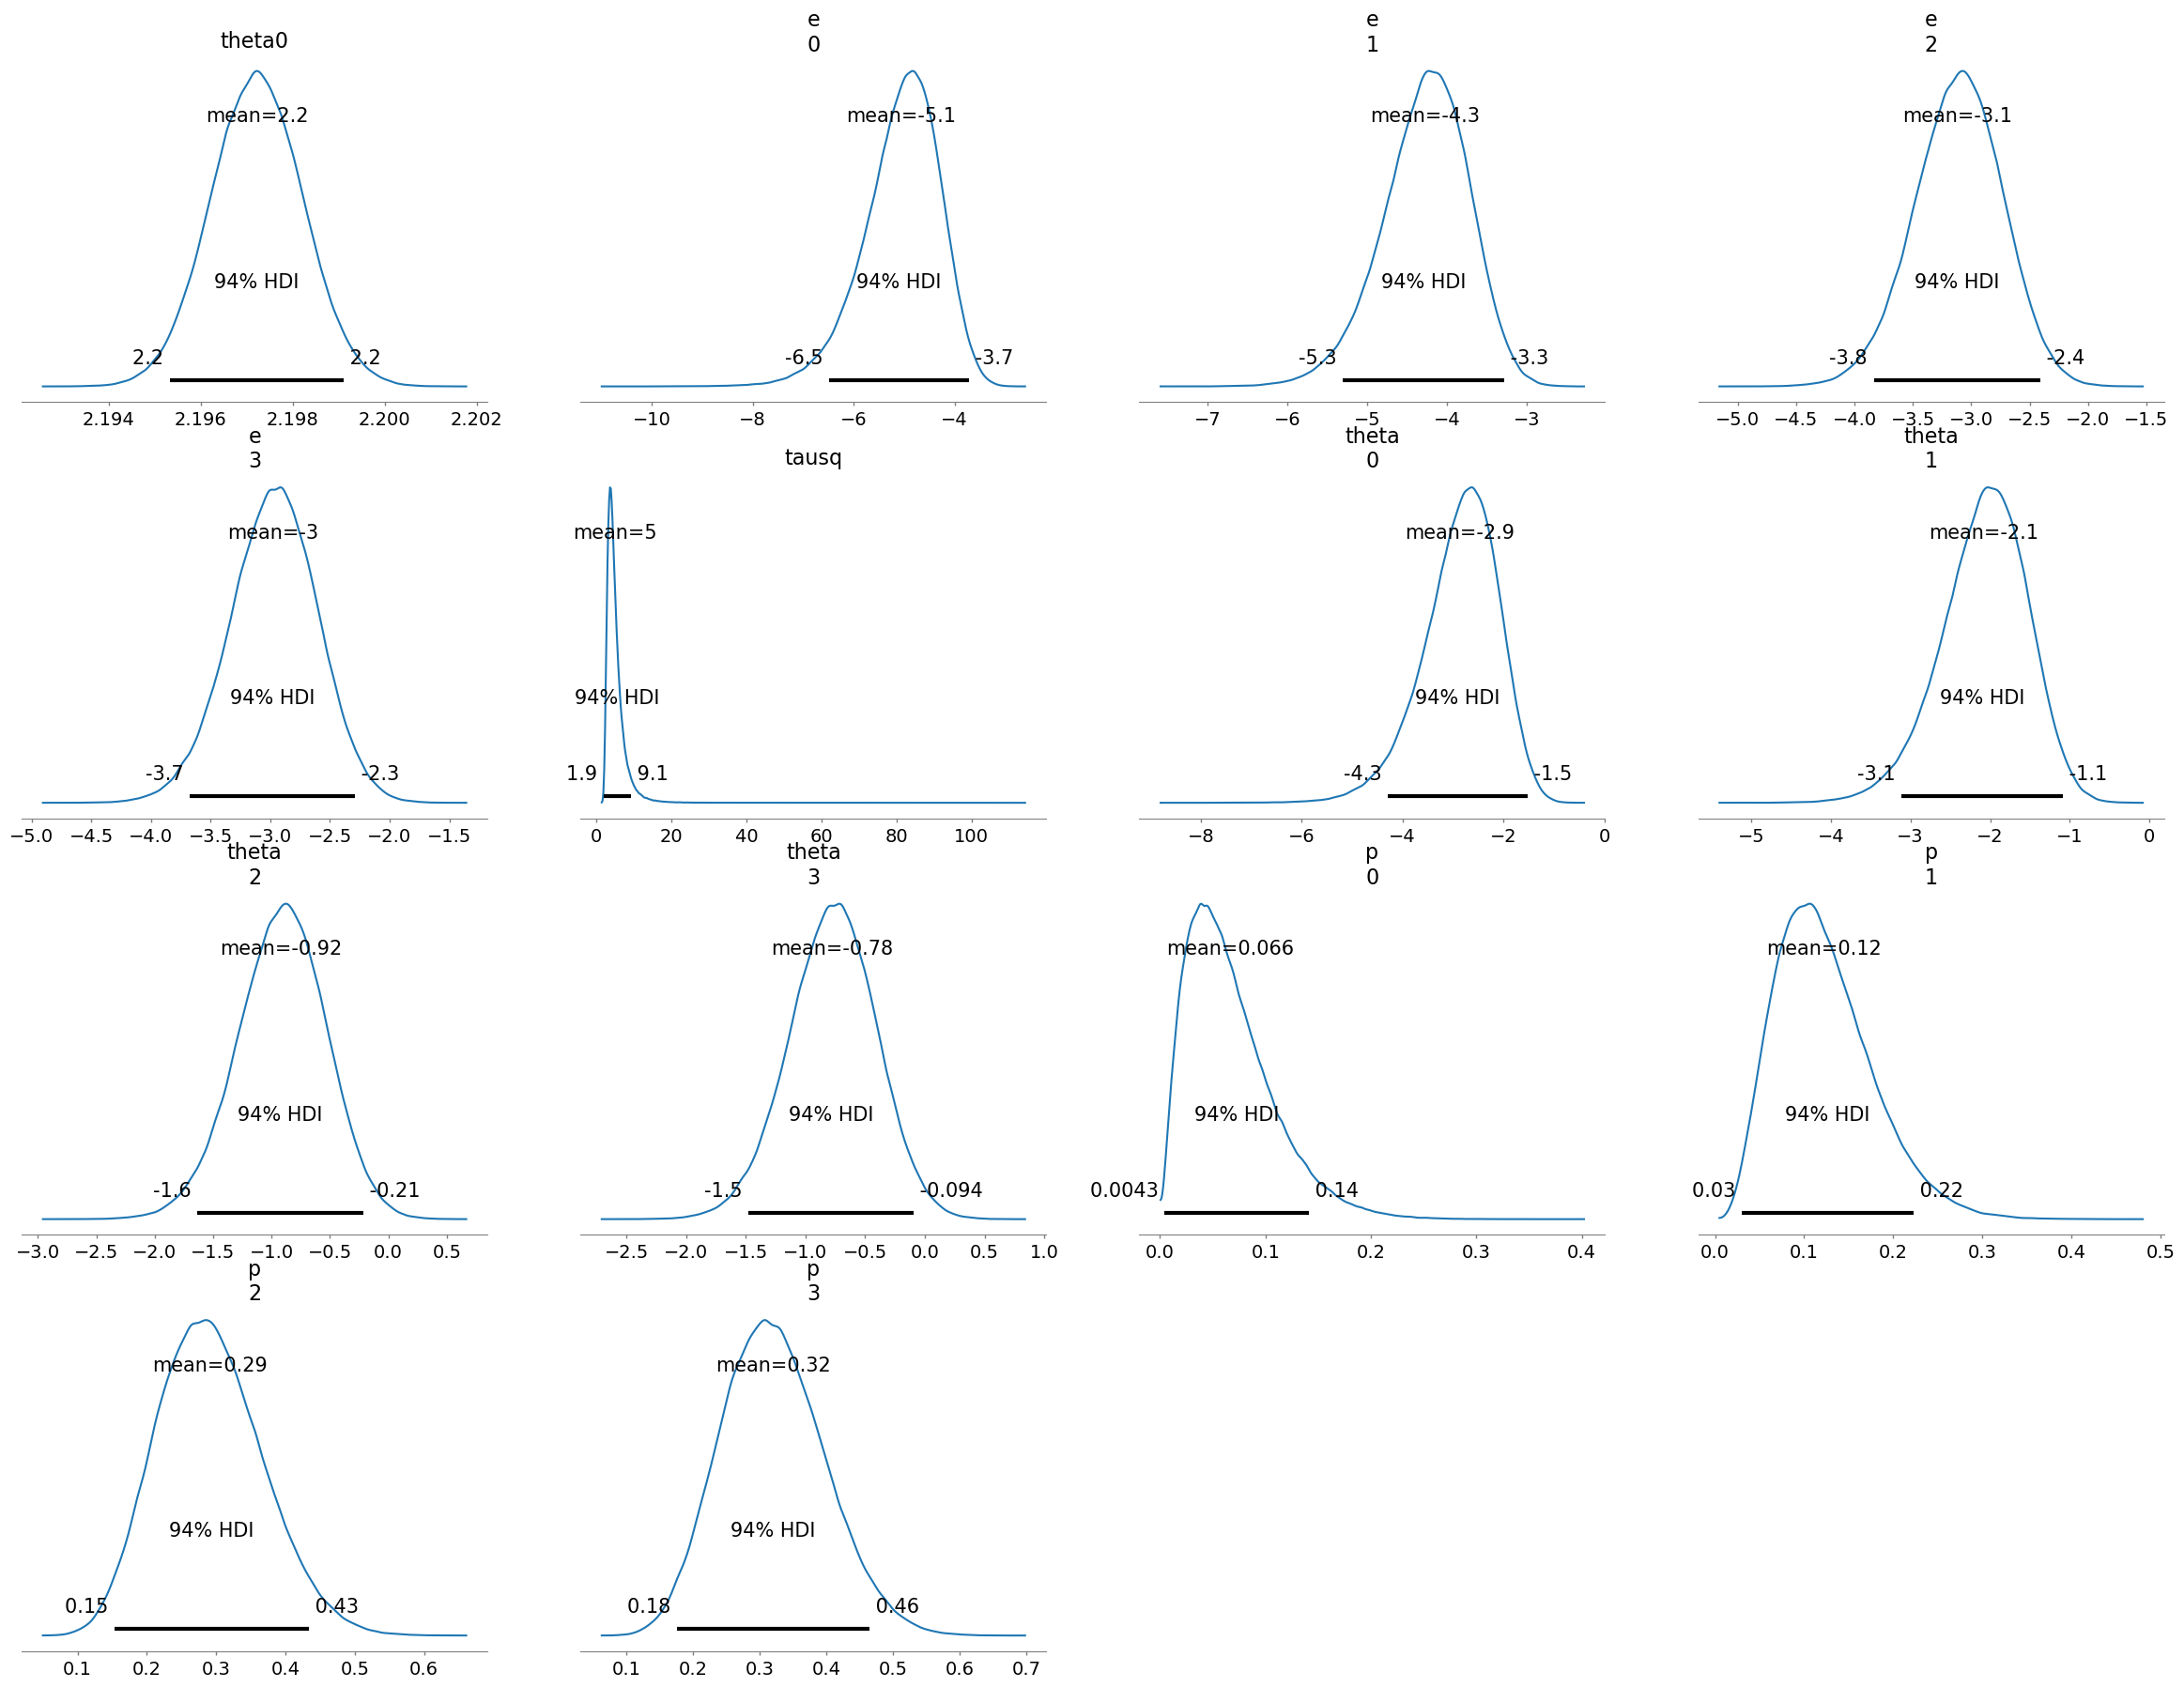

In [34]:
trial.plot_posterior(model_name, -1)